In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

from quick_downloader import QuickDownloader
from chrome_utils import GrafanaUrlInputs
from processor.load import load_sum_total, load_mean_df
from processor.filters import cut_by_window
import pandas as pd
import numpy as np
import seaborn as sns

import matplotx  # Assuming matplotx is installed

In [2]:
from typing import Callable


def load_request_per_scenario(path: str, rate_columns: tuple[str, ...] = ("total",)) -> pd.DataFrame:
    df = load_sum_total(path)
    for col in rate_columns:
        df[f"{col}_rate"] = df[col].diff() / df["dT"]
    return df


def get_os_and_processor(name: str) -> tuple[str, str]:
    os = "Windows" if "perfw" in name.lower() else "Linux"
    processor = "AMD" if "amd" in name.lower() else "Intel"
    return os, processor


def merge_dashboards(stored_data: dict[str, dict], dashboard_name: str, loader: Callable[[str], pd.DataFrame]):
    dfs = []
    for data in stored_data.values():
        vus = data["vus"]
        test_instance, identifier = data["instance_identifier"]
        dashboards = data["dashboards"]
        df = loader(dashboards[dashboard_name])
        df["vus"] = vus
        df["instance"] = "{} {}".format(*get_os_and_processor(test_instance))
        df["identifier"] = identifier
        df["os"], df["processor"] = get_os_and_processor(test_instance)
        dfs.append(df)

    merged = pd.concat(dfs)
    merged = merged.sort_index()
    merged = merged.reset_index().set_index("Time")

    return merged

In [3]:
def filter_wrong_totals(df: pd.DataFrame, total_column="total", grouper_column="instance") -> pd.DataFrame:
    result = []
    for _, column_group in df.groupby(grouper_column):
        filtered = column_group[column_group[total_column].diff() >= 0]
        result.append(filtered)
    return pd.concat(result)

In [4]:
def plot_throughput_hist(
        x_col: str,
        df: pd.DataFrame,
        unit: str,
        ylabel: str,
        title: str,
        ax: plt.Axes | None = None
):
    instances = df["instance"].unique()
    palette = dict(zip(instances, sns.color_palette("tab10", len(instances))))

    plt.rcParams["text.usetex"] = True

    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 2.5))

    sns.histplot(df.reset_index(), x=x_col, hue="instance", kde=True, palette=palette, ax=ax, multiple="layer")

    line_handles = []
    data = {}
    for name, group in df.groupby("instance"):
        mean = group[x_col].mean()
        ax.axvline(mean, color=palette[name], linestyle="-")
        line_handles.append(mlines.Line2D([], [], color=palette[name], linestyle="-", label=rf"$\bar{{x}}$"))
        std = group[x_col].std()

        p25 = np.percentile(group[x_col], 25)
        p75 = np.percentile(group[x_col], 75)
        ax.axvline(p25, color=palette[name], linestyle=":")
        ax.axvline(p75, color=palette[name], linestyle=":")

        line_handles.append(mlines.Line2D([], [], color=palette[name], linestyle=":", label="25th/75th pct"))

        data[name] = {"mean": mean, "std": std}

    hist_handles = [
        mlines.Line2D(
            [], [], color=palette[name], marker='s', linestyle='',
            label=rf"{name} $\bar{{x}}$={data[name]['mean']:0.2f} [{unit}] $\sigma$={data[name]['std']:0.2f} [{unit}]"
        )
        for name in instances
    ]

    hist_handles.extend(line_handles)
    legend1 = ax.legend(handles=hist_handles, title="", loc="upper left")
    ax.add_artist(legend1)

    plt.title(title)
    plt.xlabel(unit)
    plt.ylabel(ylabel)
    if ax is None:
        plt.show()


def plot_over_time(df: pd.DataFrame, y_col: str, title: str, ylabel: str, grouper: str = "instance",
                   ax: plt.Axes | None = None):

    instances = df[grouper].unique()
    palette = dict(zip(instances, sns.color_palette("tab10", len(instances))))

    if ax is None:
        fig, ax = plt.subplots(figsize=(7.5, 5))
    for name, group in df.groupby(grouper):
        color = palette.get(name)
        group.plot(use_index=True, y=y_col, label=name, ax=ax, color=color)
    plt.title(title)
    plt.ylabel(ylabel)
    if ax is None:
        plt.show()


def plot_bar(df: pd.DataFrame, x_col: str, y_col: str, title: str, ylabel: str, grouper: str = "instance",
             errorbar: str = "sd",
             legend: bool = True,
             show_numbers: bool = True,
             ax: plt.Axes | None = None, estimator="max", fmt="%.0f"):
    instances = df[grouper].unique()
    palette = dict(zip(instances, sns.color_palette("tab10", len(instances))))

    if ax is None:
        fig, ax = plt.subplots(figsize=(7.5, 5))

    sns.barplot(
        data=df.reset_index(),
        x=x_col, y=y_col, hue=grouper,
        ax=ax, palette=palette, errorbar=errorbar, legend=legend, estimator=estimator
    )
    if show_numbers:
        for container in ax.containers:
            ax.bar_label(container, fmt=fmt)

    plt.title(title)
    plt.ylabel(ylabel)
    if ax is None:
        plt.show()


def plot_cat_bar(
        df: pd.DataFrame,
        y_col: str,
        axis_labels: tuple[str, str],
        title: str,
        x_col: str = "processor",
        hue_col: str = "os",
        row_col: str = "vus",
        errorbar: str = "sd",
        palette: dict = None,
):
    instances = df[hue_col].unique()
    if palette is None:
        palette = dict(zip(instances, sns.color_palette("tab10", len(instances))))
    g = sns.catplot(
        data=df.reset_index(), kind="bar",
        x=x_col, y=y_col, hue=hue_col, row=row_col,
        errorbar=errorbar, palette=palette
    )
    g.despine(left=True)
    g.set_axis_labels(*axis_labels)
    plt.title(title)
    plt.show()
    return g

def plot_grouped_means_with_palette(
        df: pd.DataFrame,
        value_col: str,
        ax: plt.Axes,
        group_col: str = "instance",
        palette_name: str = "tab10",
        line_style: str = "--",
        label_fmt: str = r"$\bar{{x}}$={mean:.2f}s $\sigma$={std:.2f}s"
):
    instances = df[group_col].unique()
    palette = dict(zip(instances, sns.color_palette(palette_name, len(instances))))
    for name, group in df.groupby(group_col):
        mean_value = group[value_col].mean()
        std_value = group[value_col].std()
        ax.axhline(
            mean_value,
            color=palette[name],
            linestyle=line_style,
            label=label_fmt.format(mean=mean_value, std=std_value)
        )

def save_plot_if_new(filename: str, dpi: int = 300, style: str = matplotx.styles.dracula, force: bool = False):
    """
    Save the current matplotlib figure to `filename` only if it does not exist.
    """
    if force and os.path.exists(filename):
        os.remove(filename)

    if not os.path.exists(filename):
        if style:
            with plt.style.context(style):
                plt.savefig(filename, dpi=dpi, transparent=True)
        else:
            plt.savefig(filename, dpi=dpi, transparent=True)
        print(f"Plot saved to {filename}")

## Data loading

In [5]:
from_ts = "2025-08-21 13:36:30"  # Example timestamp
to_ts = "2025-08-21 14:58:30"  # Example timestamp
var_scenario = "ARInvoiceTracker"
resource_groups = "rgQAToolsSaaSAKSResources-EastUS"
names_space = "perflamd1"
vus = 494
l1 = GrafanaUrlInputs(from_ts, to_ts, names_space, "l1", vus, var_scenario, resource_groups)

from_ts = "2025-08-21 18:00:00"  # Example timestamp
to_ts = "2025-08-22 19:15:00"  # Example timestamp
var_scenario = "ARInvoiceTracker"
resource_groups = "rgQAToolsSaaSAKSResources-EastUS"
names_space = "perfwamd2"
w2 = GrafanaUrlInputs(from_ts, to_ts, names_space, "l2", vus, var_scenario, resource_groups)

downloader = QuickDownloader([l1, w2])
data_ = downloader.download()

In [6]:
total_requests = merge_dashboards(data_, "Total Requests per Scenario", load_request_per_scenario)
total_iterations = merge_dashboards(data_, "Iterations per Scenario", load_request_per_scenario)
mean_ttfb = merge_dashboards(data_, "TTFB per Scenario", load_mean_df)
mean_request_duration = merge_dashboards(data_, "Request Duration per Scenario p99", load_mean_df)

In [7]:
total_requests = cut_by_window(total_requests, "20m", "40m")
total_requests = filter_wrong_totals(total_requests, "total", "instance")
total_iterations = cut_by_window(total_iterations, "20m", "40m")
total_iterations = filter_wrong_totals(total_iterations)
mean_ttfb = cut_by_window(mean_ttfb, "20m", "40m")
mean_request_duration = cut_by_window(mean_request_duration, "20m", "40m")

In [8]:
skip_columns = ["dT", "vus", "identifier", "os", "processor", "instance","total_rate", "total"]
scenarios = [col for col in total_requests.columns if col not in skip_columns]

## Requests Analysis

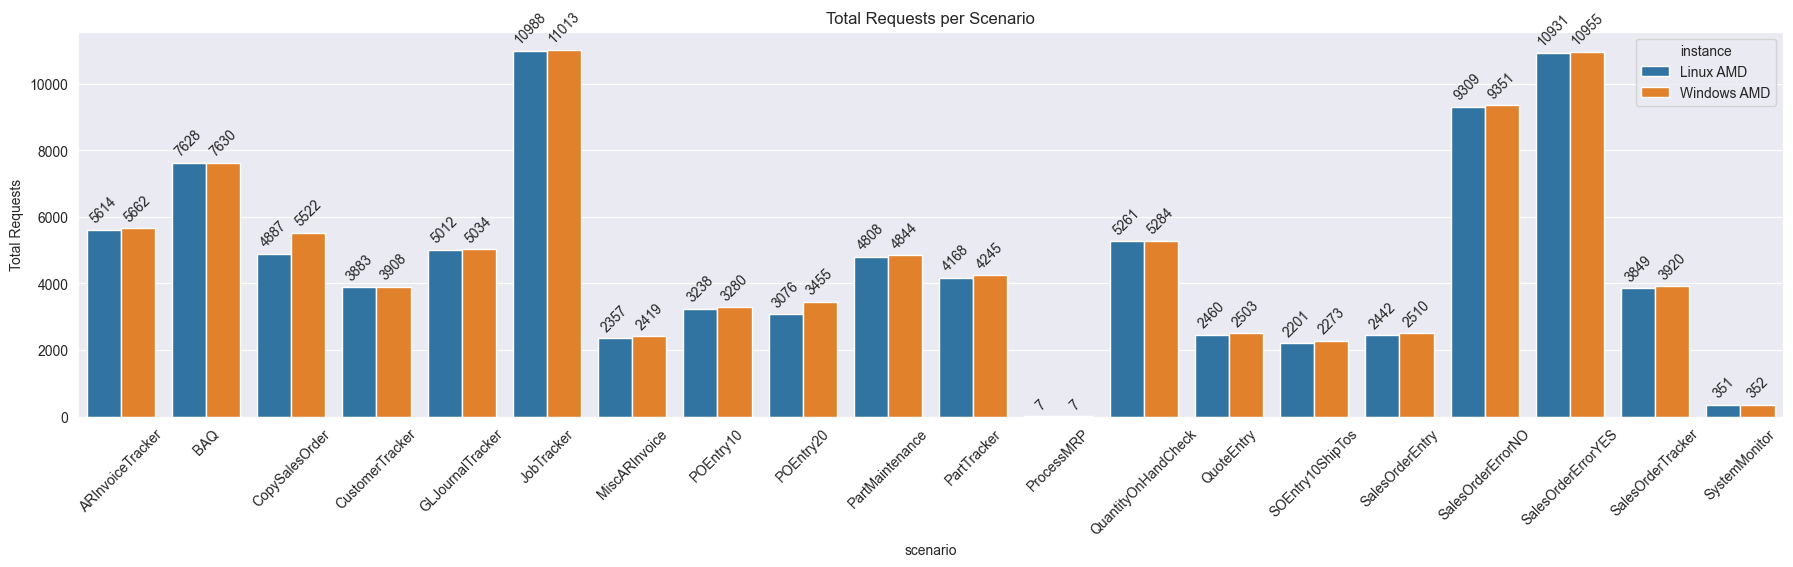

In [9]:
def plot_bars(df:pd.DataFrame, to_process=scenarios,summarizer: str="max", grouper: str="instance", ax: plt.Axes | None = None, title:str="", ylabel:str=""):
    if ax is None:
        fig, ax = plt.subplots(figsize=(22, 5))

    processing = df[[grouper] + to_process].groupby(grouper).agg(summarizer).reset_index()
    melted = processing.melt(id_vars=grouper, value_vars=to_process, var_name="scenario", value_name="value")
    ax = sns.barplot(data=melted, x="scenario", y="value", hue=grouper, ax=ax)
    for container in ax.containers:
        ax.bar_label(container, fmt="%.0f", rotation=45, padding=3)
    ax.tick_params(axis='x', rotation=45)
    ax.set_title(title)
    ax.set_ylabel(ylabel)



plot_bars(total_requests, title="Total Requests per Scenario", ylabel="Total Requests")

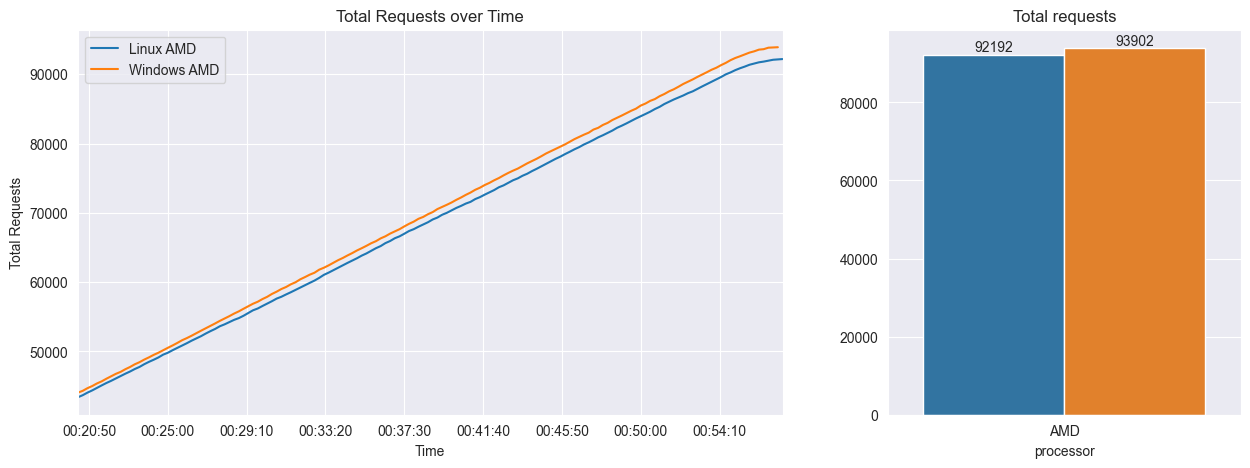

In [10]:
fig = plt.figure(figsize=(15, 5))  # Increase width
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # 2/3 and 1/3

ax1 = fig.add_subplot(gs[0])
plot_over_time(total_requests, "total", 'Total Requests over Time', 'Total Requests', ax=ax1)
ax2 = fig.add_subplot(gs[1])
plot_bar(total_requests, "processor", "total", "Total requests", "", ax=ax2, legend=False, show_numbers=True, errorbar=None)
plt.show()

Plot saved to results/Requests Throughput Distribution.png


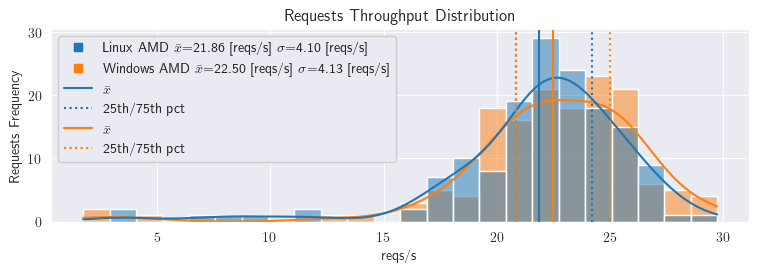

In [11]:
plot_throughput_hist(
    x_col="total_rate",
    df=total_requests,
    unit=r"{reqs/s}",
    ylabel="Requests Frequency",
    title="Requests Throughput Distribution")
save_plot_if_new("results/Requests Throughput Distribution.png", dpi=300)
plt.show()

In [12]:
total_requests.groupby("instance").agg({"total_rate": ['mean', 'std'], "total": ['mean', 'std', "max"]})

total_rate                   total                       
                  mean       std          mean           std      max
instance                                                             
Linux AMD    21.859111  4.104275  68667.266667  14712.894828  92192.0
Windows AMD  22.495302  4.134047  69708.597315  14979.495703  93902.0

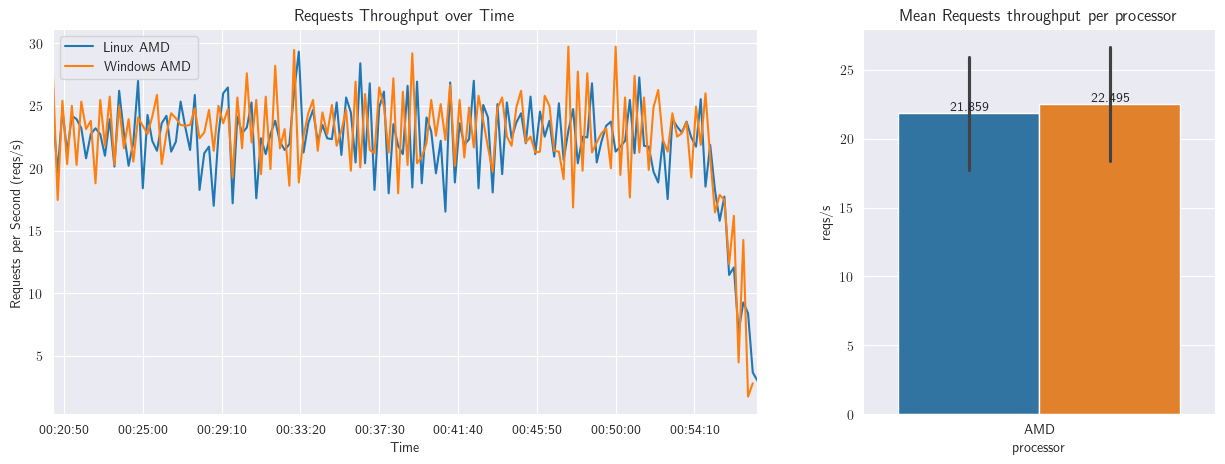

In [13]:
fig = plt.figure(figsize=(15, 5))  # Increase width
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # 2/3 and 1/3
ax1 = fig.add_subplot(gs[0])
plot_over_time(total_requests, "total_rate", 'Requests Throughput over Time', 'Requests per Second (reqs/s)', ax=ax1)
ax2 = fig.add_subplot(gs[1])
plot_bar(total_requests, "processor", "total_rate", "Mean Requests throughput per processor", "reqs/s", ax=ax2, legend=False,
         show_numbers=True, errorbar="sd", estimator="mean", fmt="%.3f")
plt.show()

## Iterations Analysis

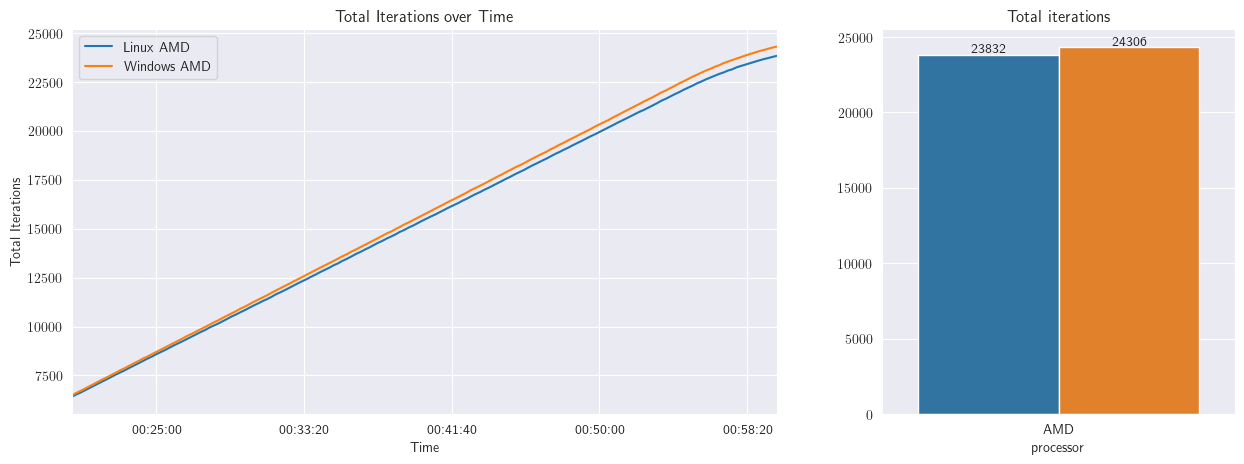

In [14]:
fig = plt.figure(figsize=(15, 5))  # Increase width
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # 2/3 and 1/3

ax1 = fig.add_subplot(gs[0])
plot_over_time(total_iterations, "total", 'Total Iterations over Time', 'Total Iterations', ax=ax1)
ax2 = fig.add_subplot(gs[1])
plot_bar(total_iterations, "processor", "total", "Total iterations", "", ax=ax2, legend=False, show_numbers=True,
         errorbar=None)
plt.show()

Plot saved to results/Iterations Throughput Distribution.png


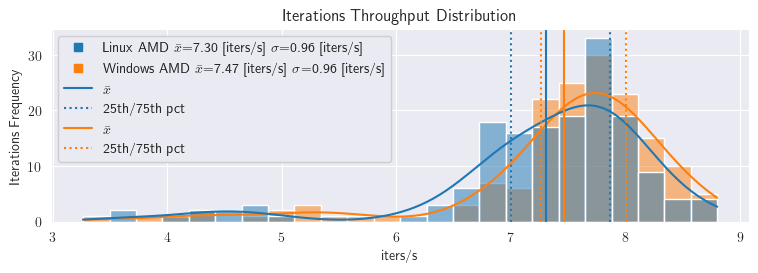

In [15]:
plot_throughput_hist(
    x_col="total_rate",
    df=total_iterations,
    unit=r"{iters/s}",
    ylabel="Iterations Frequency",
    title="Iterations Throughput Distribution")
save_plot_if_new("results/Iterations Throughput Distribution.png", dpi=300)
plt.show()

In [16]:
total_iterations.groupby("instance").agg({"total_rate": ['mean', 'std'], "total": ['mean', 'std', "max"]})

total_rate                  total                      
                  mean       std         mean          std      max
instance                                                           
Linux AMD     7.301667  0.960752  15423.57500  5214.770824  23832.0
Windows AMD   7.465833  0.957897  15707.04375  5334.868822  24306.0

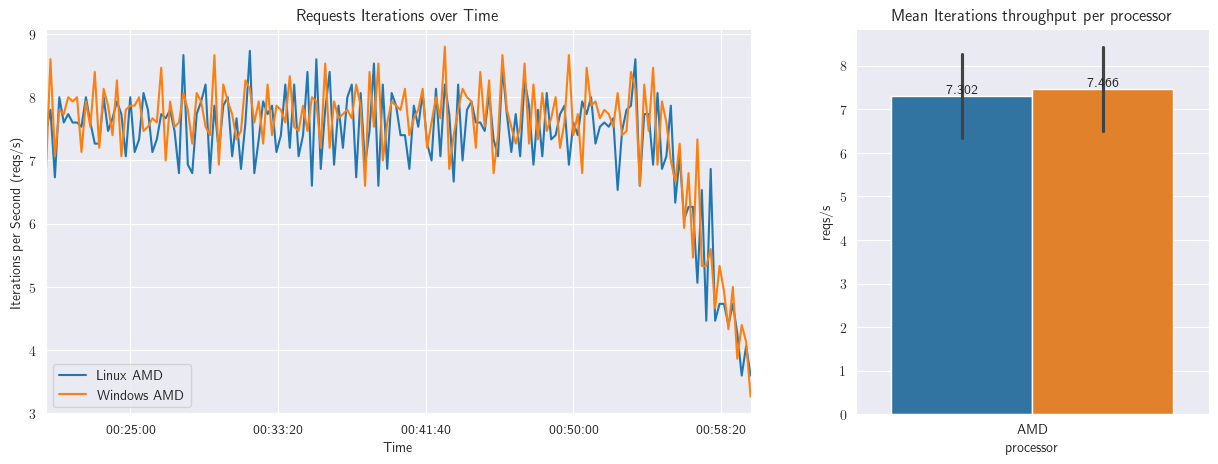

In [17]:
fig = plt.figure(figsize=(15, 5))  # Increase width
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # 2/3 and 1/3
ax1 = fig.add_subplot(gs[0])
plot_over_time(total_iterations, "total_rate", 'Requests Iterations over Time', 'Iterations per Second (reqs/s)',
               ax=ax1)
ax2 = fig.add_subplot(gs[1])
plot_bar(total_iterations, "processor", "total_rate", "Mean Iterations throughput per processor", "reqs/s", ax=ax2,
         legend=False, show_numbers=True, errorbar="sd", estimator="mean", fmt="%.3f")
plt.show()

## TTFB analysis

Plot saved to results/Mean TTFB over Time.png


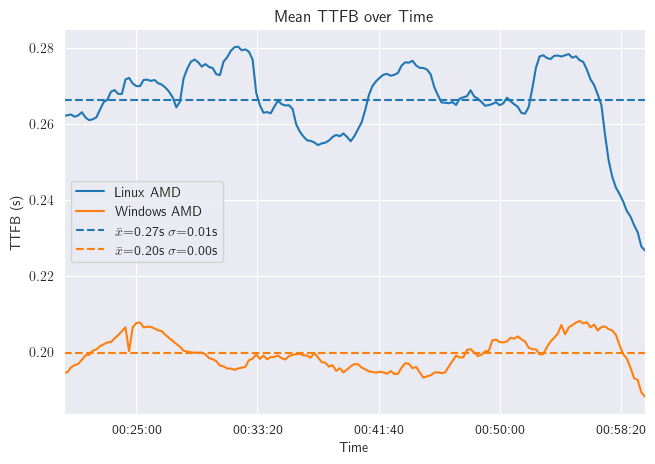

In [18]:
fig, ax = plt.subplots(figsize=(7.5, 5))

mean_ttfb["mean"] =mean_ttfb[scenarios].mean(axis=1)

# Plot the time series
plot_over_time(mean_ttfb, "mean", 'Mean TTFB over Time', 'TTFB (s)', ax=ax)
plot_grouped_means_with_palette(mean_ttfb, "mean", ax)

ax.legend()
save_plot_if_new("results/Mean TTFB over Time.png", dpi=300)
plt.show()

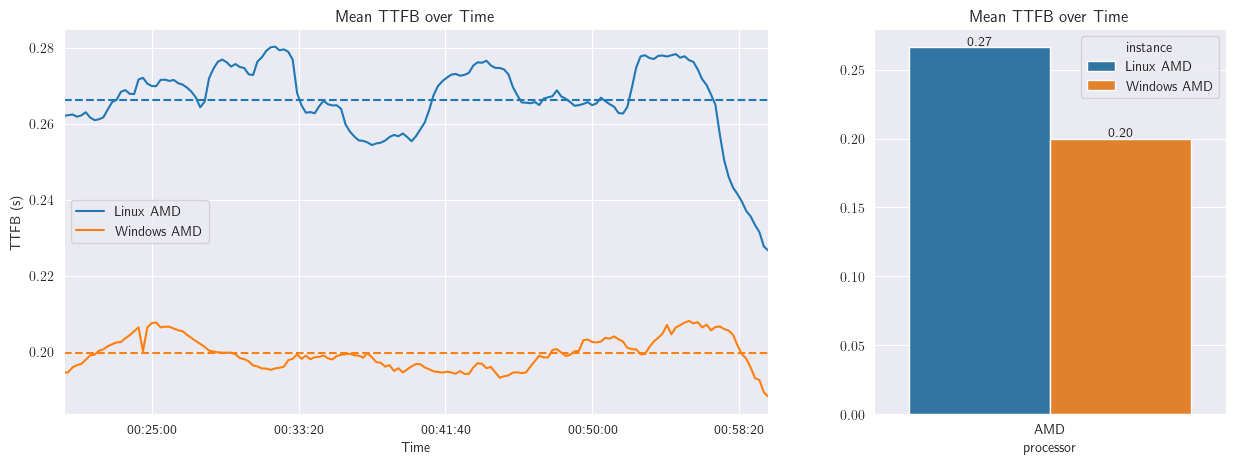

In [19]:
fig = plt.figure(figsize=(15, 5))  # Increase width
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # 2/3 and 1/3

ax1 = fig.add_subplot(gs[0])
plot_over_time(mean_ttfb, "mean", 'Mean TTFB over Time', 'TTFB (s)', ax=ax1)
plot_grouped_means_with_palette(mean_ttfb, "mean", ax1)

ax2 = fig.add_subplot(gs[1])
plot_bar(mean_ttfb, "processor", "mean", "Mean TTFB over Time", "", ax=ax2, show_numbers=True, errorbar=None,
         estimator="mean", fmt="%.2f")
plt.show()

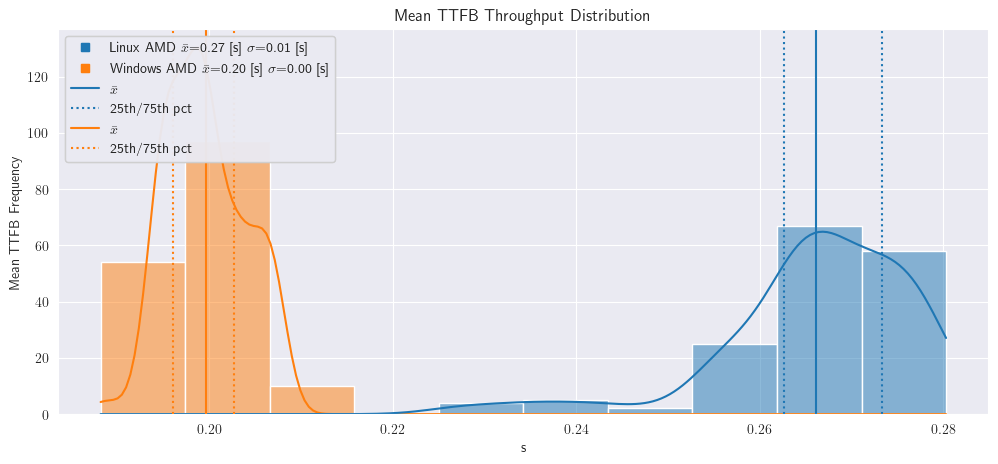

mean                             
                 mean      std       max       min
instance                                          
Linux AMD    0.266183  0.01039  0.280311  0.226626
Windows AMD  0.199626  0.00427  0.208095  0.188189

In [20]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_throughput_hist(
    x_col="mean",
    df=mean_ttfb,
    unit=r"s",
    ylabel="Mean TTFB  Frequency",
    title="Mean TTFB  Throughput Distribution", ax=ax)
plt.show()
mean_ttfb.groupby("instance").agg({"mean": ['mean', 'std', 'max', 'min']})

## Request duration P99

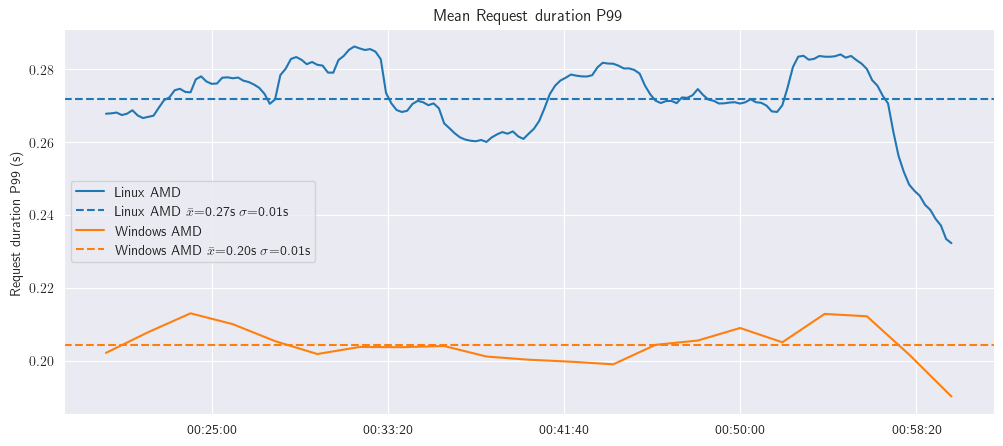

In [23]:
fig, ax = plt.subplots(figsize=(12, 5))

instances = mean_ttfb["instance"].unique()
palette = dict(zip(instances, sns.color_palette("tab10", len(instances))))

mean_request_duration["mean"] =mean_request_duration[scenarios].mean(axis=1)

def format_seconds_as_hms(x, pos):
    td = pd.to_timedelta(x, unit='s')
    total_seconds = int(td.total_seconds())
    hours = total_seconds // 3600
    minutes = (total_seconds % 3600) // 60
    seconds = total_seconds % 60
    return f"{hours:02}:{minutes:02}:{seconds:02}"

for os_name in ["Linux", "Windows"]:
    group = mean_request_duration[mean_request_duration["os"] == os_name].copy()
    group["timedelta_seconds"] = group.index.total_seconds()
    mean = group["mean"].mean()
    std = group["mean"].std()
    ax.plot(group["timedelta_seconds"], group["mean"], label=f"{os_name} AMD", color=palette[f"{os_name} AMD"])
    ax.axhline(mean, color=palette[f"{os_name} AMD"], linestyle="--",
               label=rf"{os_name} AMD $\bar{{x}}$={mean:.2f}s $\sigma$={std:.2f}s")

plt.title("Mean Request duration P99")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_seconds_as_hms))
ax.legend()
plt.ylabel("Request duration P99 (s)")
save_plot_if_new("results/Mean Request Duration P99 over Time.png", dpi=300)
plt.show()